Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

--------------------------------------------------
 >>> Starting Leave-One-Subject-Out (LOSO) CV
--------------------------------------------------
Fold  1 | Test: subject1 | MAE: 0.30 | [Pred: 20.3 / GT: 20]
Fold  2 | Test: subject2 | MAE: 10.12 | [Pred: 30.1 / GT: 20]
Fold  3 | Test: subject3 | MAE: 0.14 | [Pred: 20.1 / GT: 20]
Fold  4 | Test: subject4 | MAE: 4.14 | [Pred: 24.1 / GT: 20]
Fold  5 | Test: subject5 | MAE: 5.49 | [Pred: 14.5 / GT: 20]
Fold  6 | Test: subject6 | MAE: 2.14 | [Pred: 22.1 / GT: 20]
Fold  7 | Test: subject7 | MAE: 4.41 | [Pred: 15.6 / GT: 20]
Fold  8 | Test: subject8 | MAE: 3.11 | [Pred: 15.9 / GT: 19]
Fold  9 | Test: subject9 | MAE: 1.92 | [Pred: 17.1 / GT: 19]
Fold 10 | Test: subject10 | MAE: 1.22 | [Pred: 18.8 / GT: 20]
 >>> Final LOSO Result (Average MAE): 3.299
 >>> Standard Deviation: 2.827
 >>> Visualizing All 10 Subjects


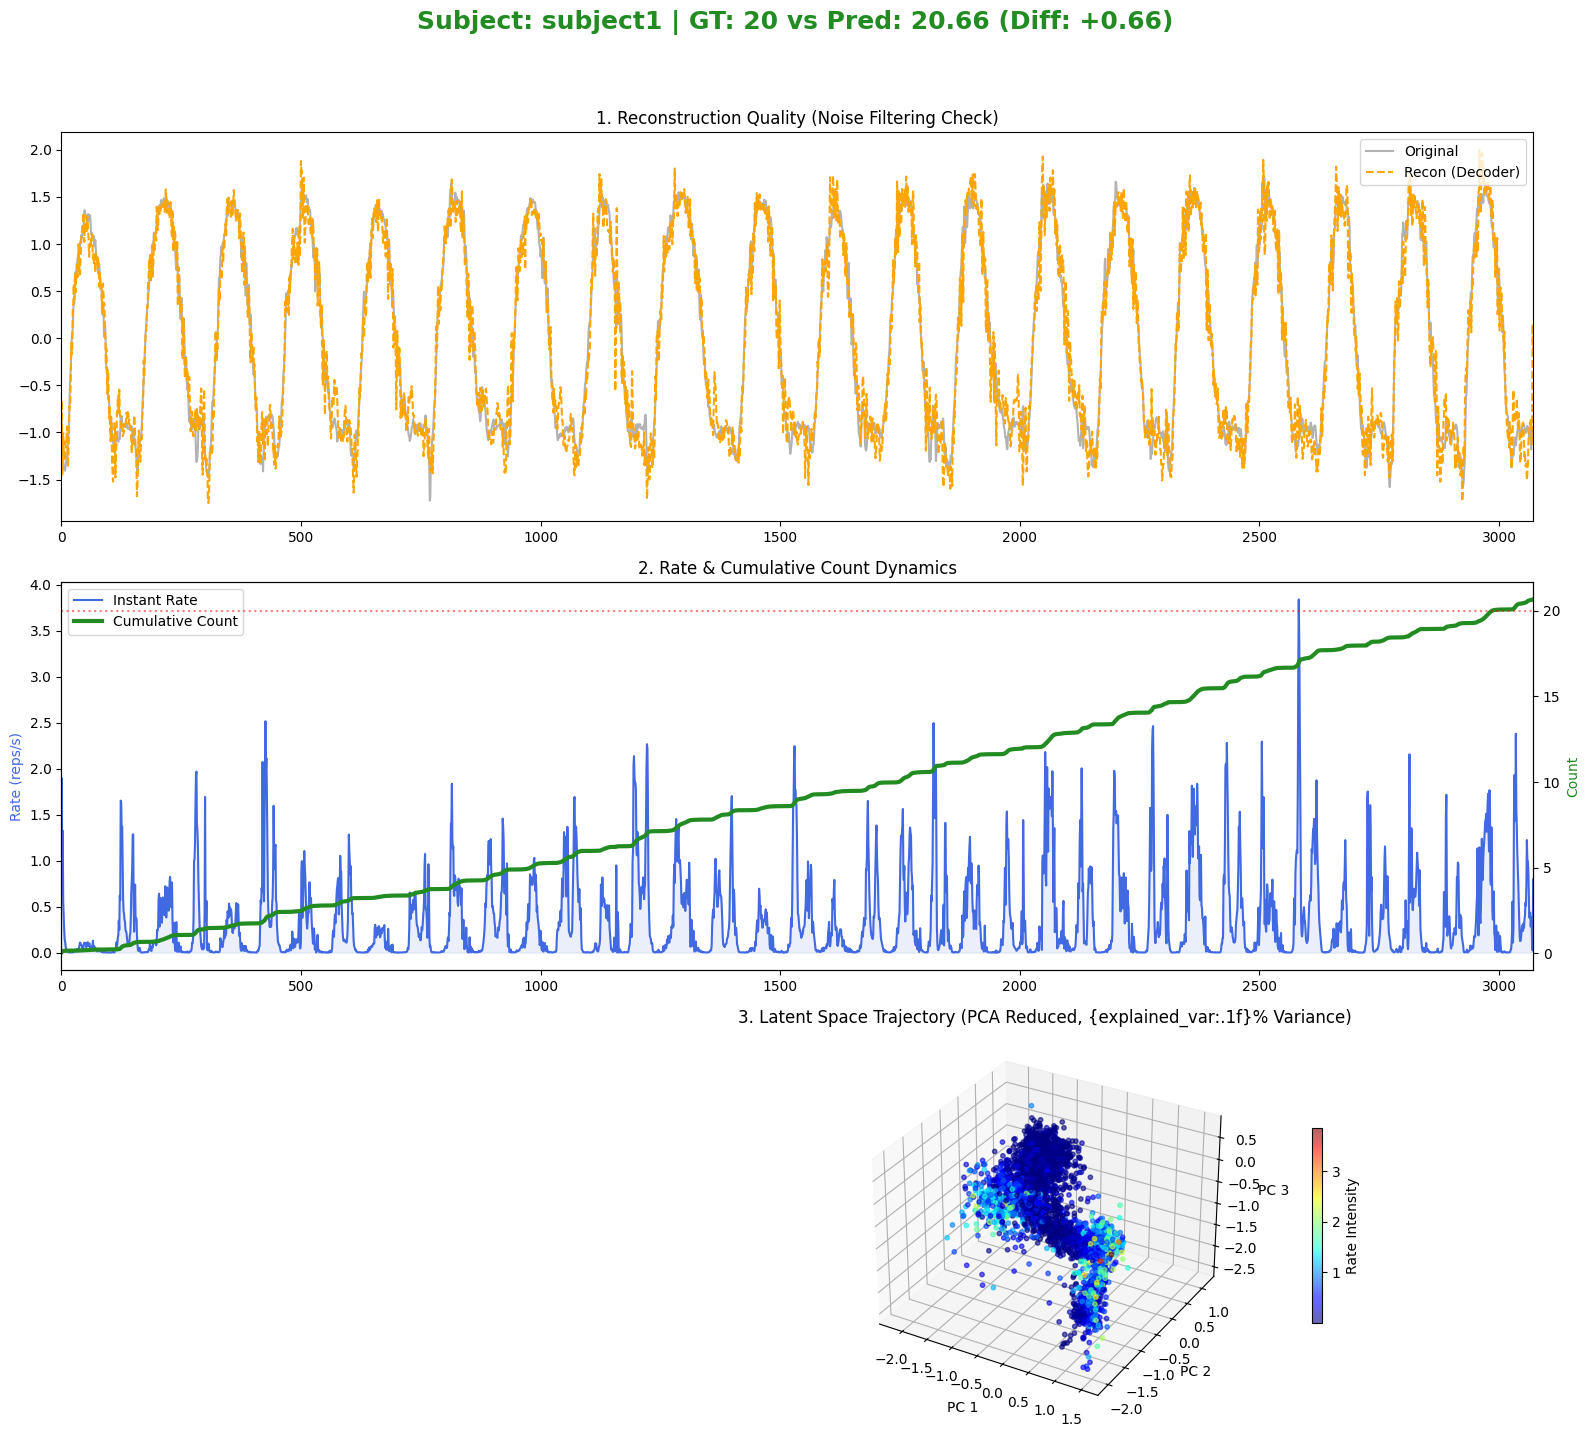

Done subject1...



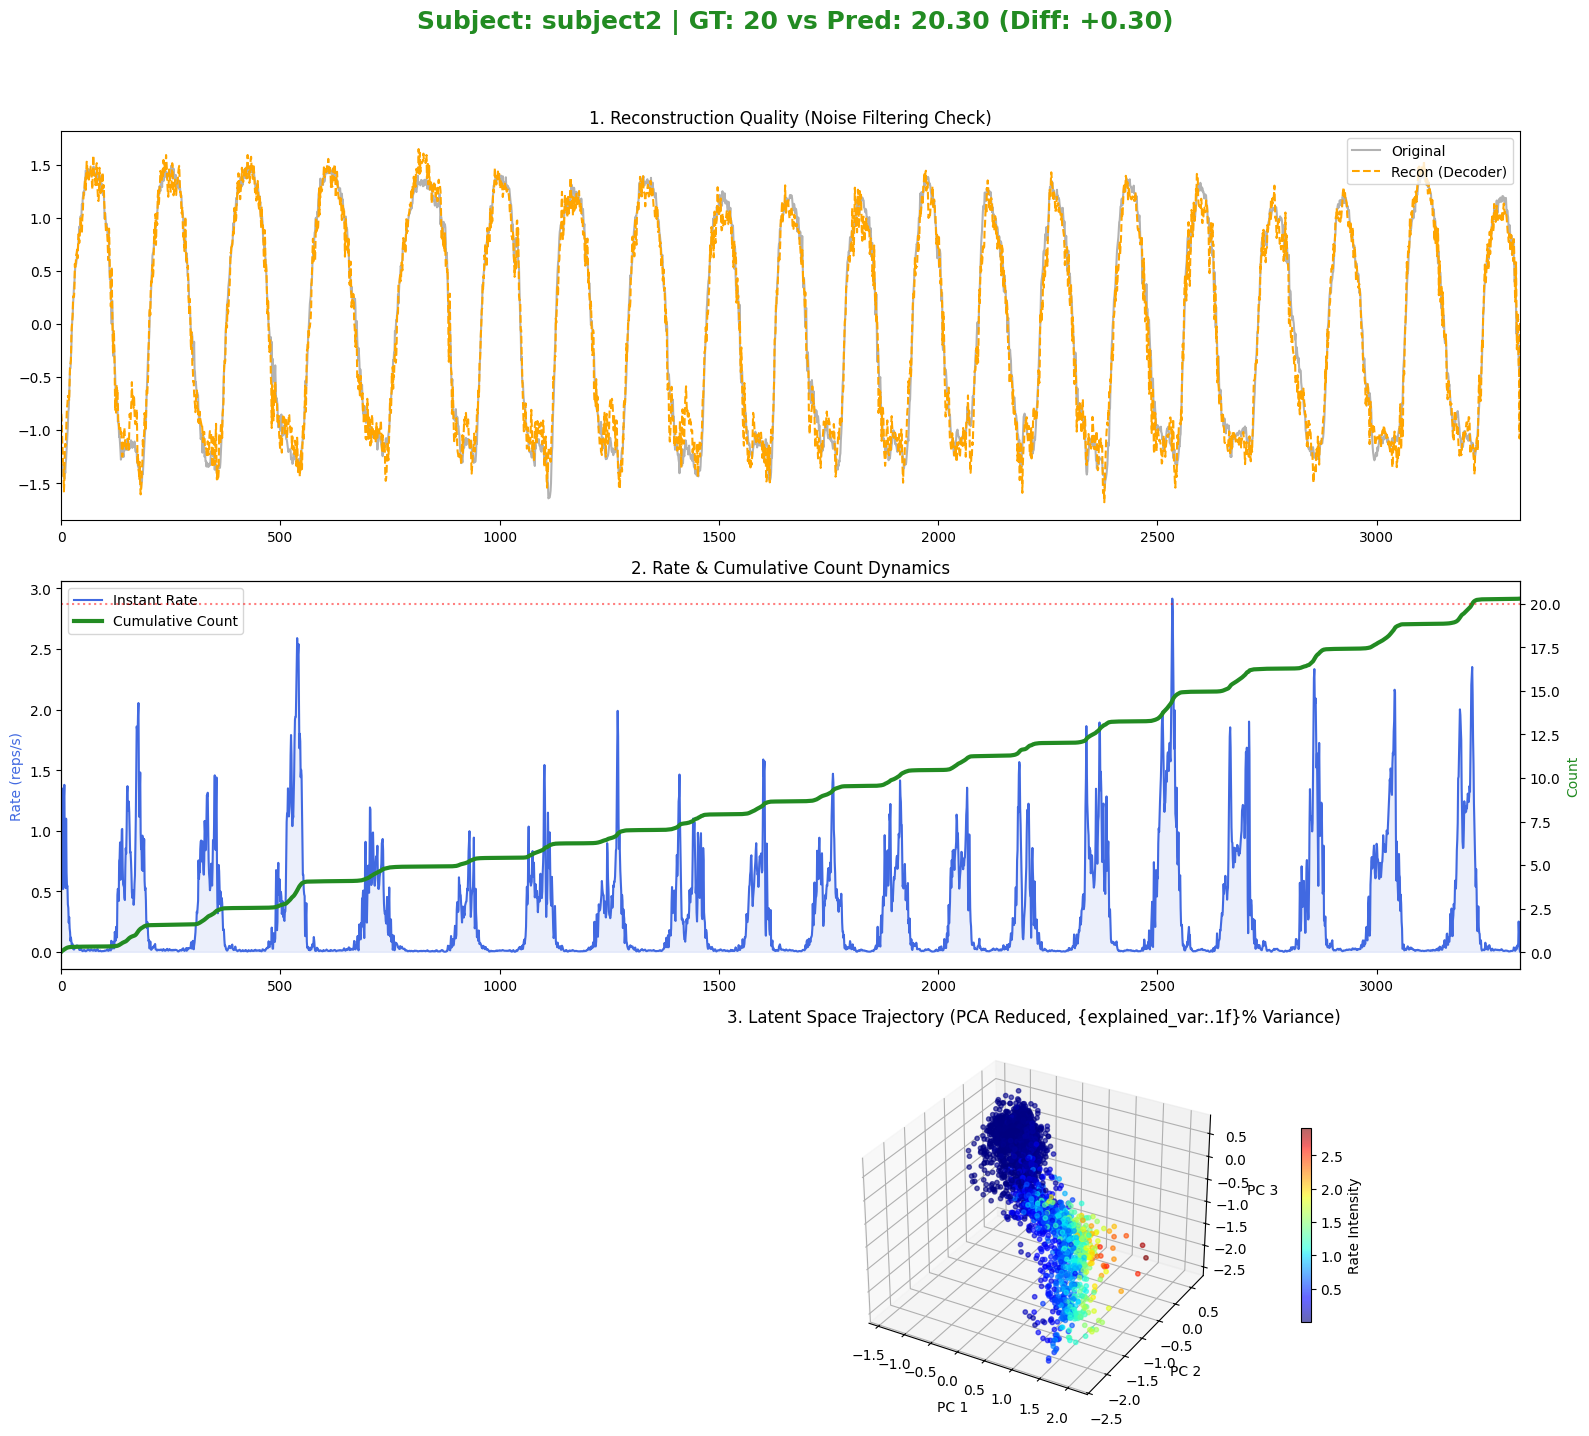

Done subject2...



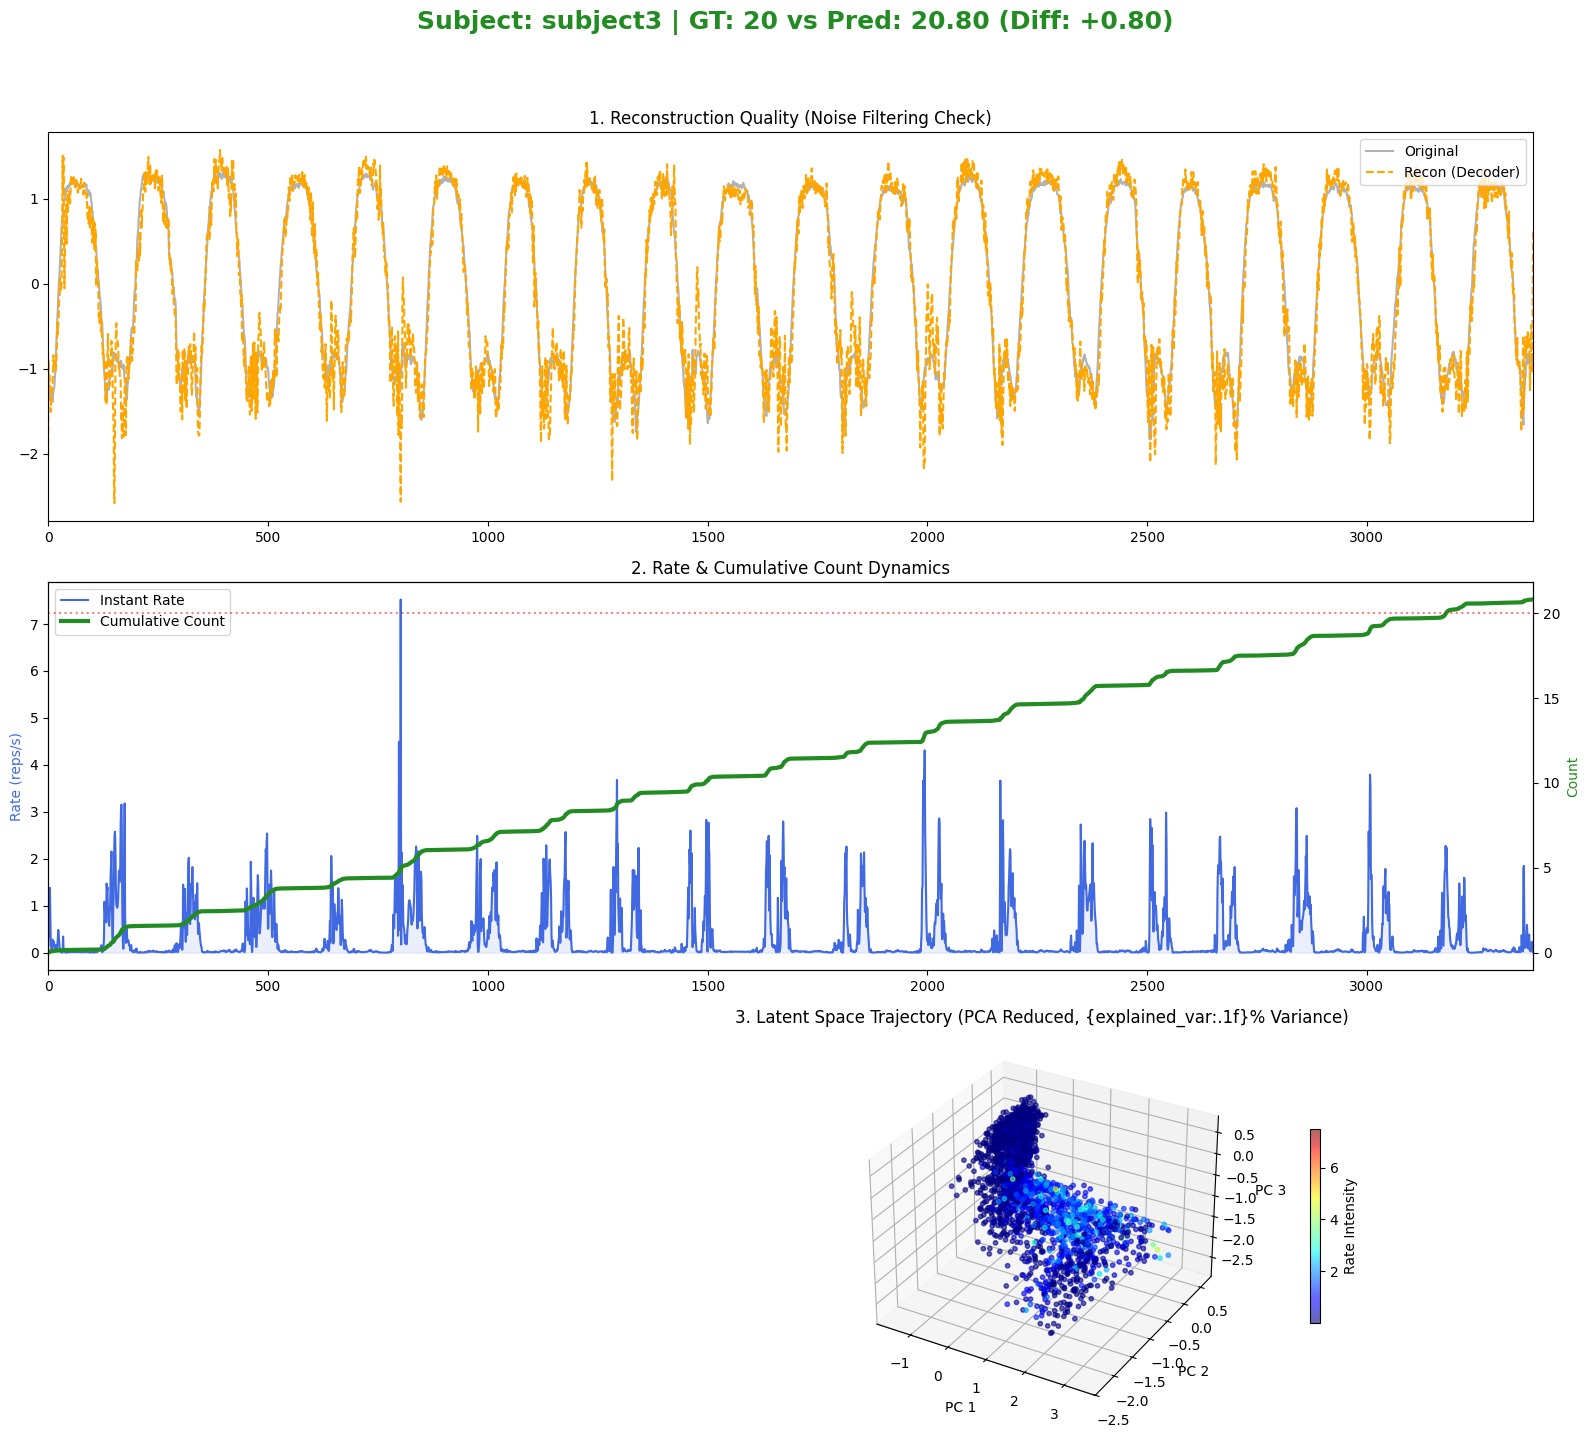

Done subject3...



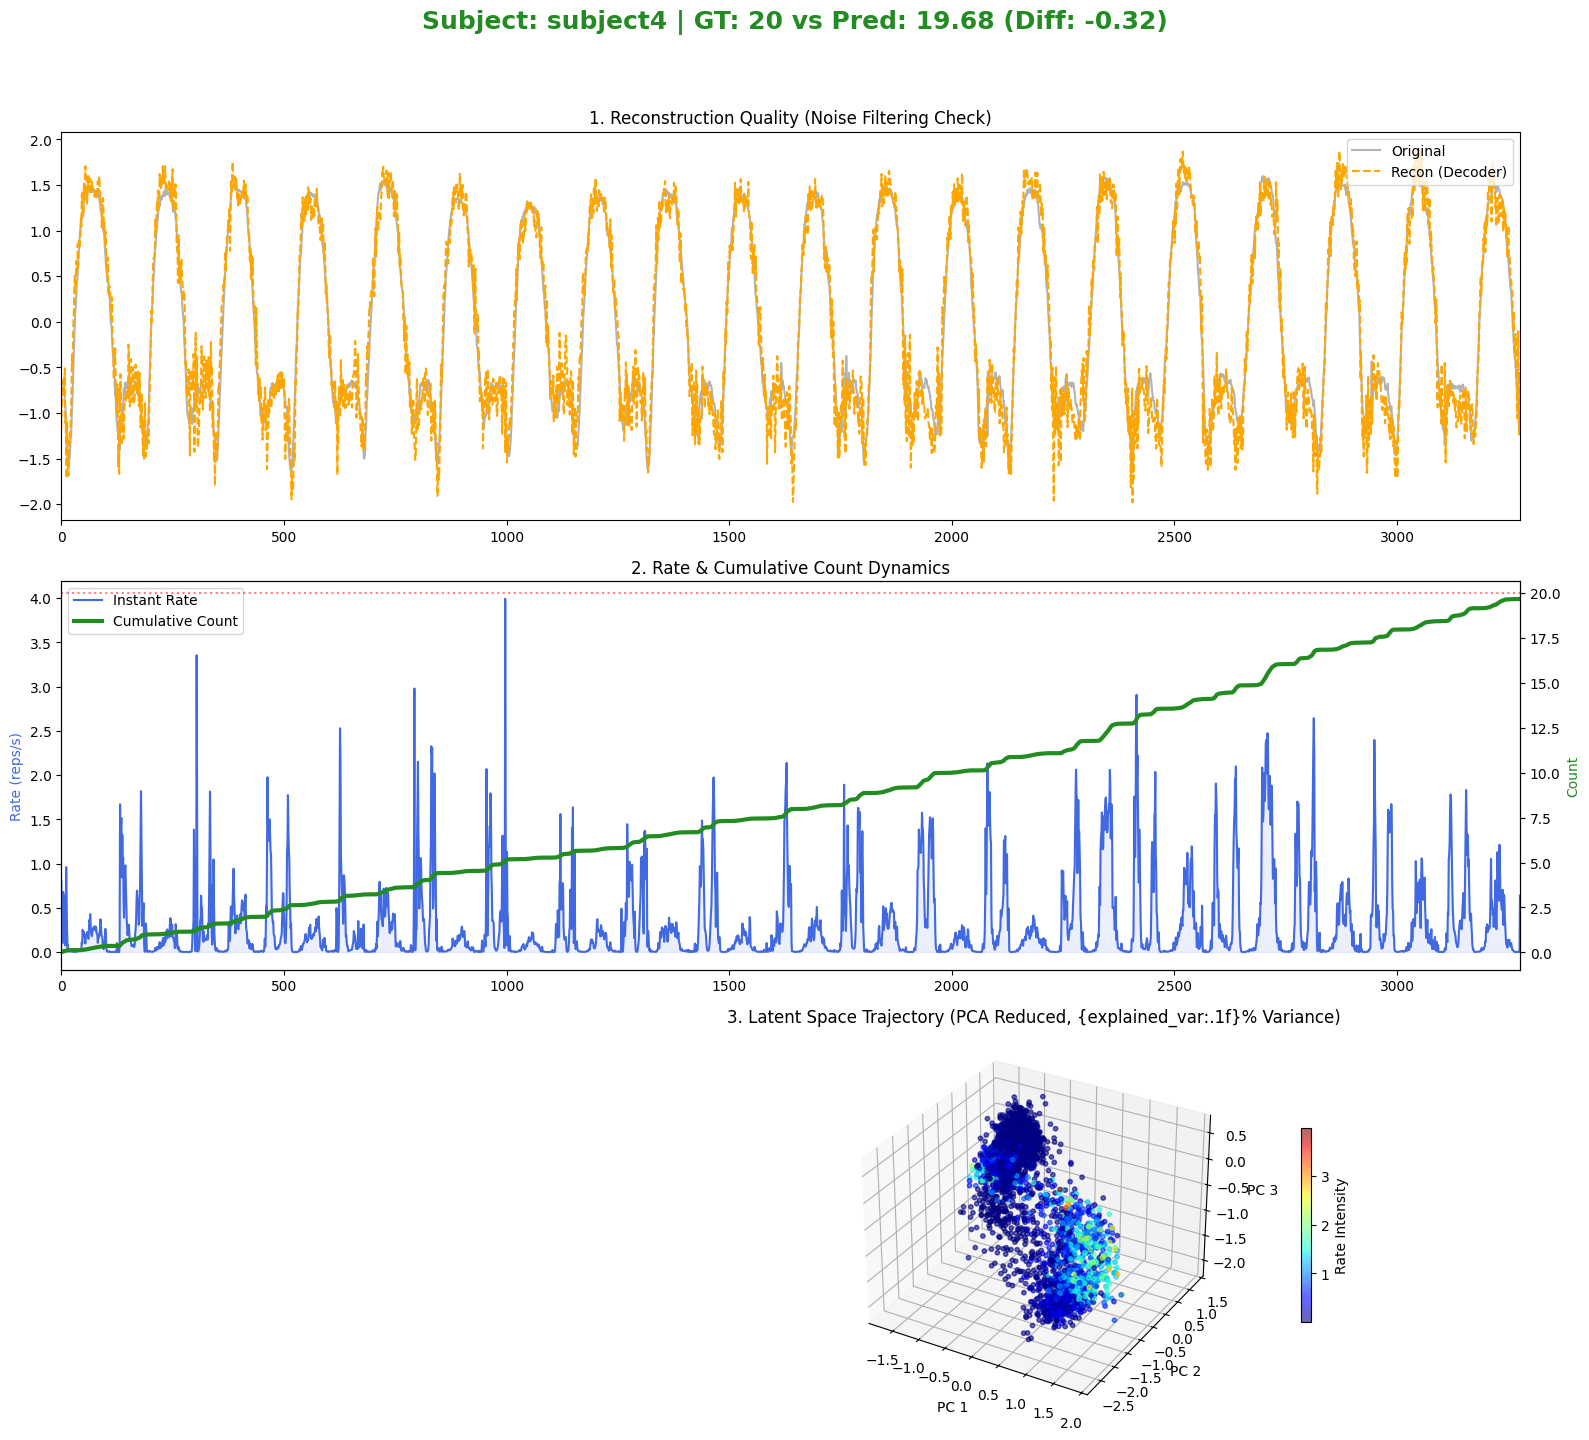

Done subject4...



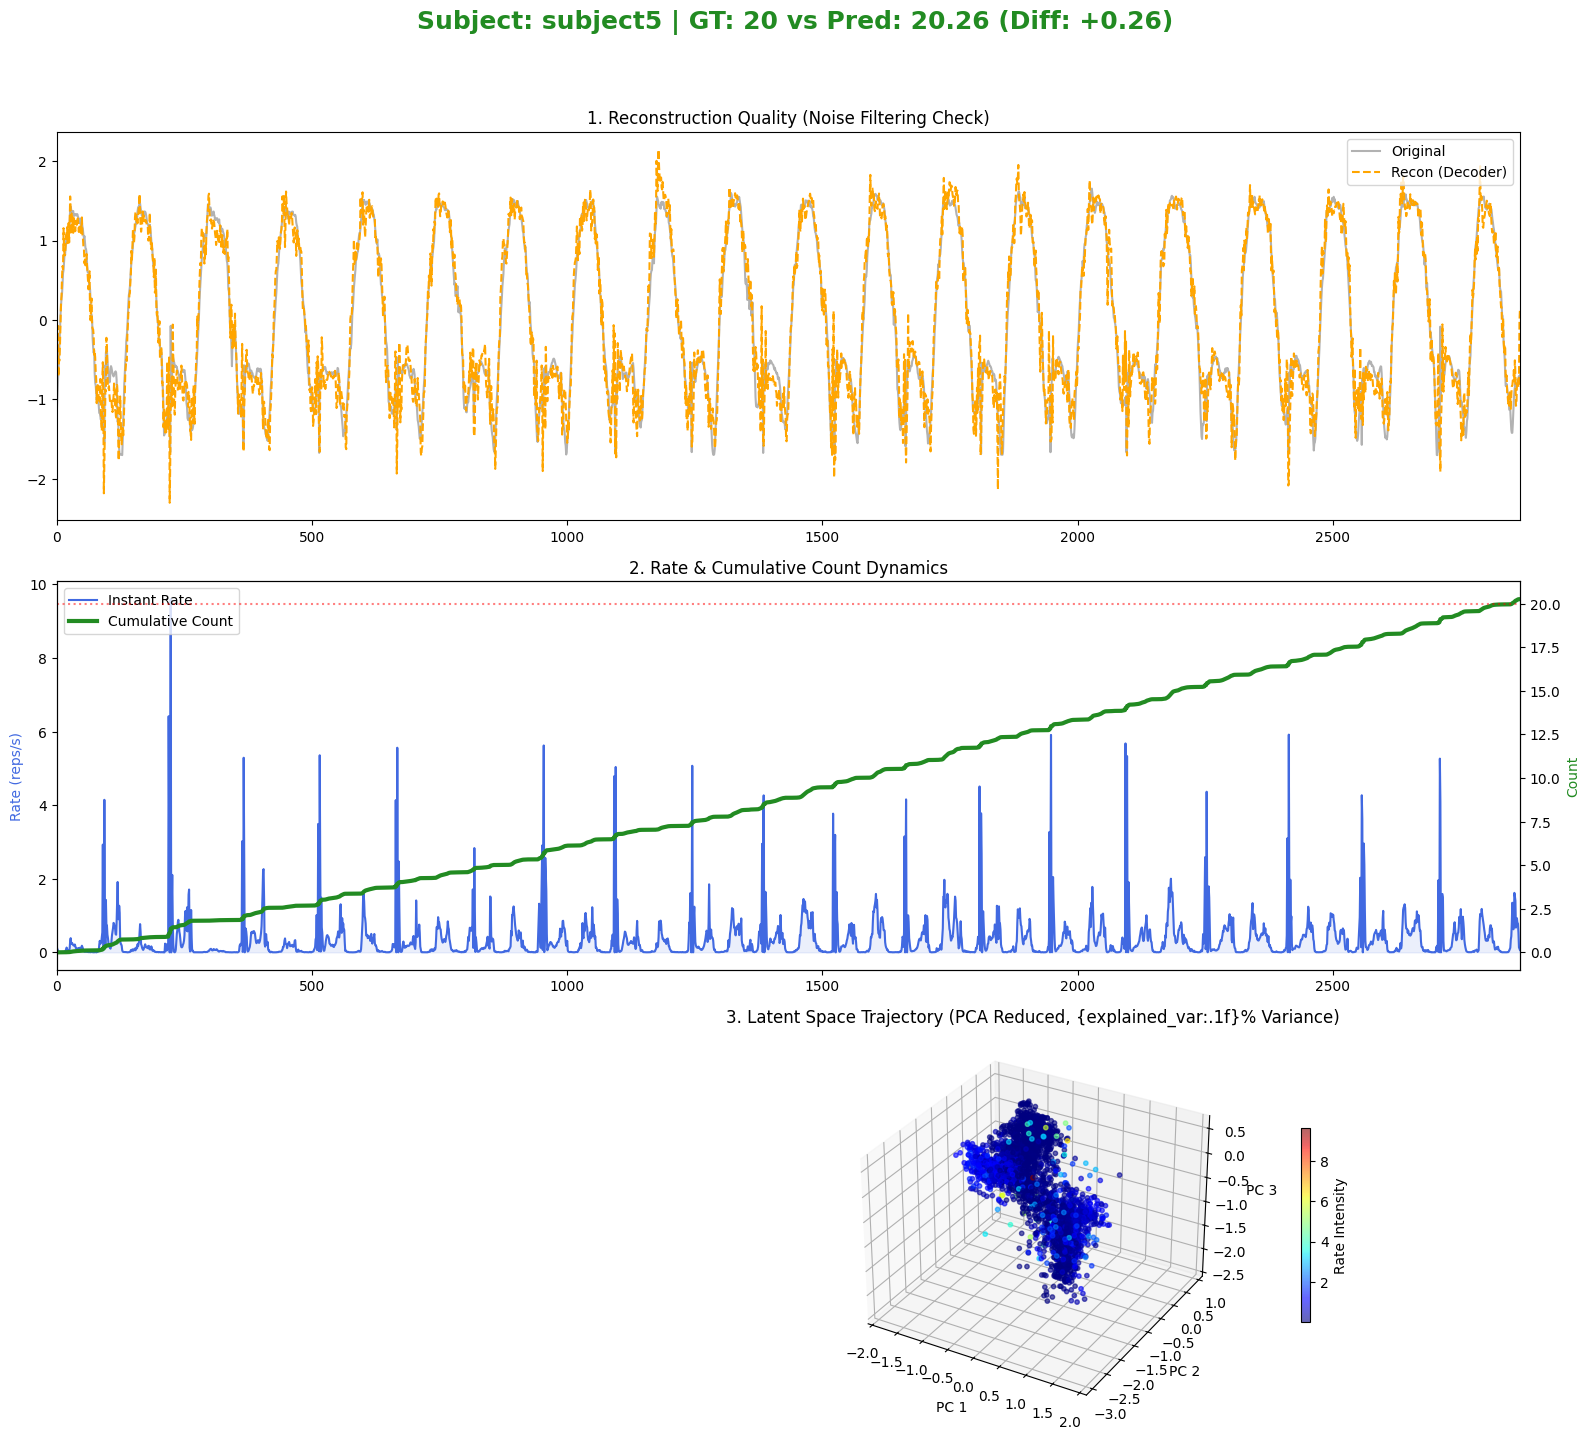

Done subject5...



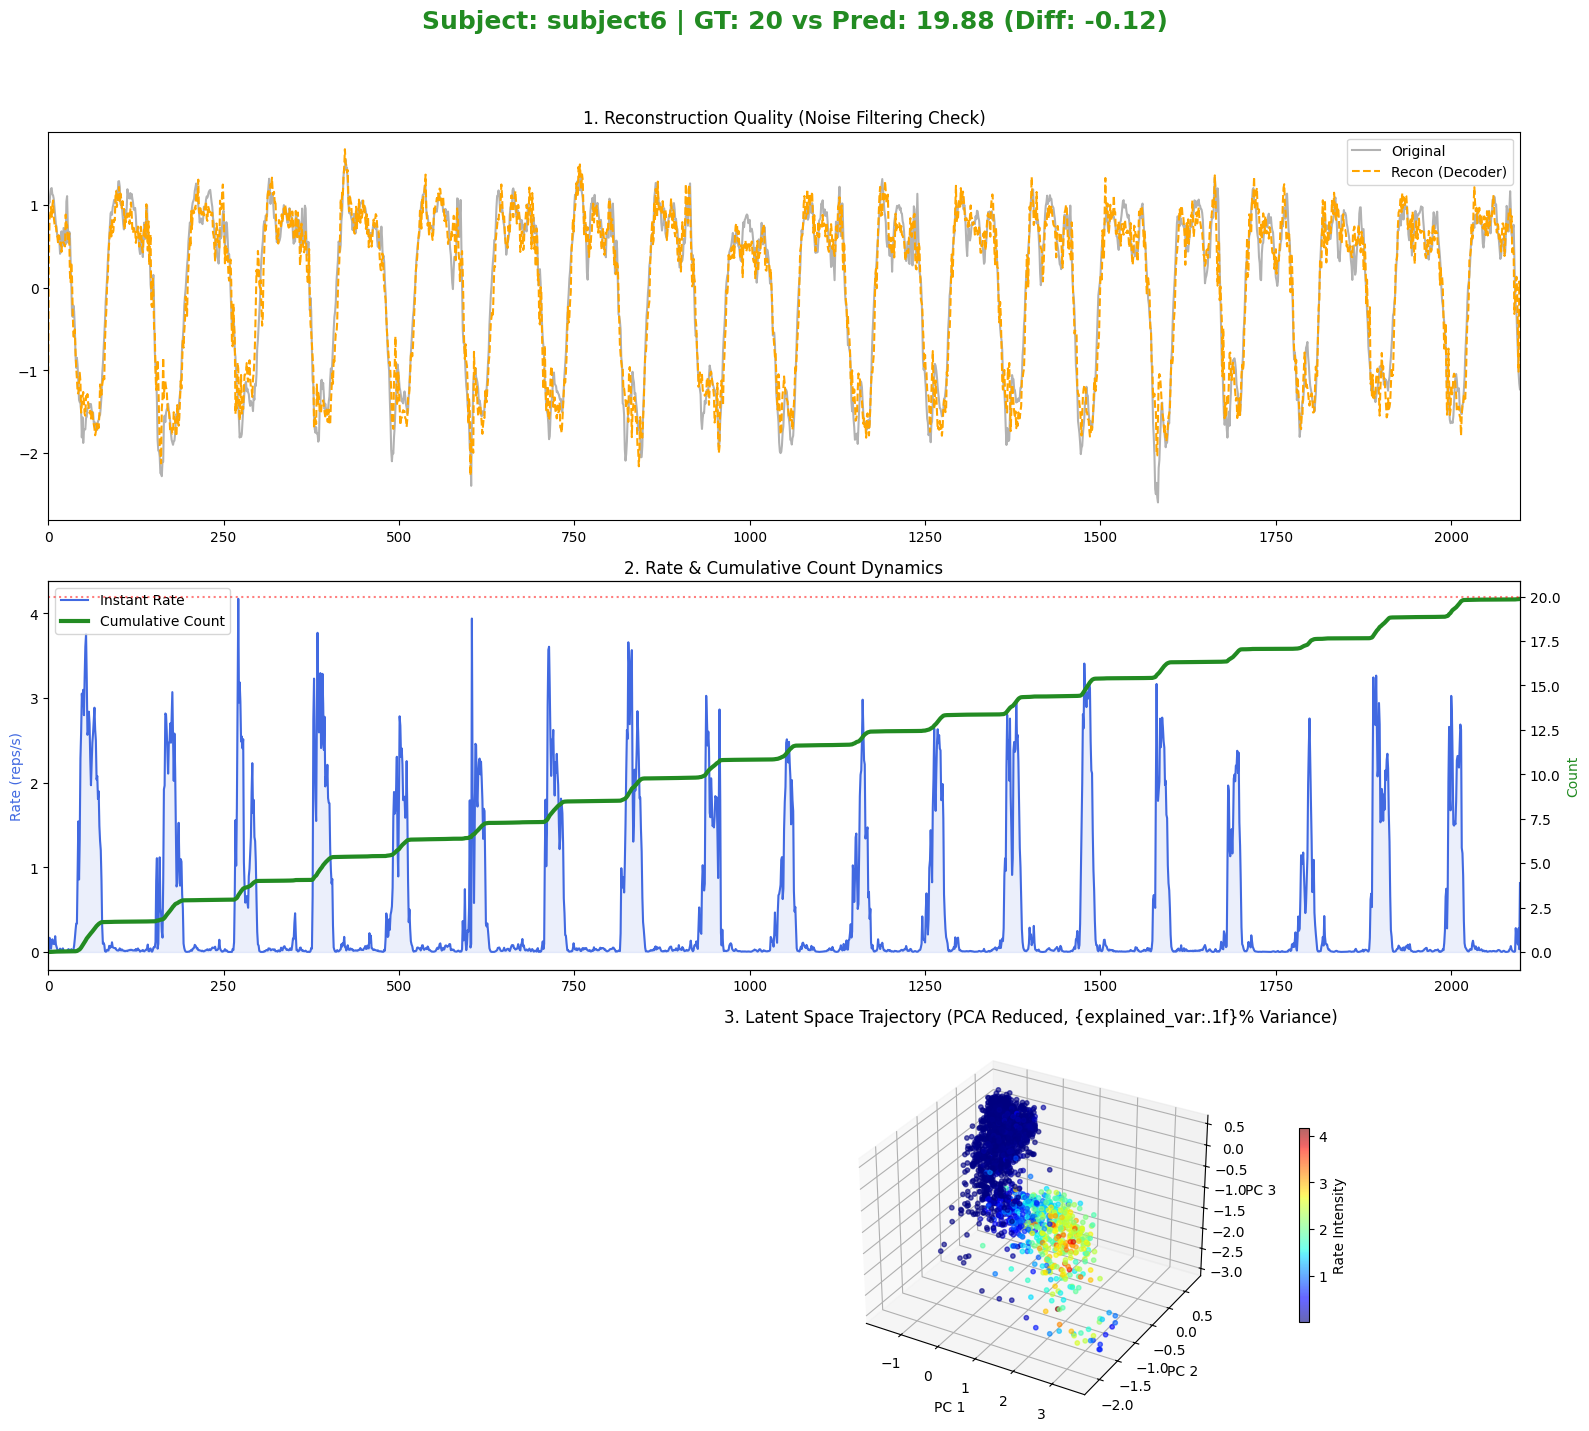

Done subject6...



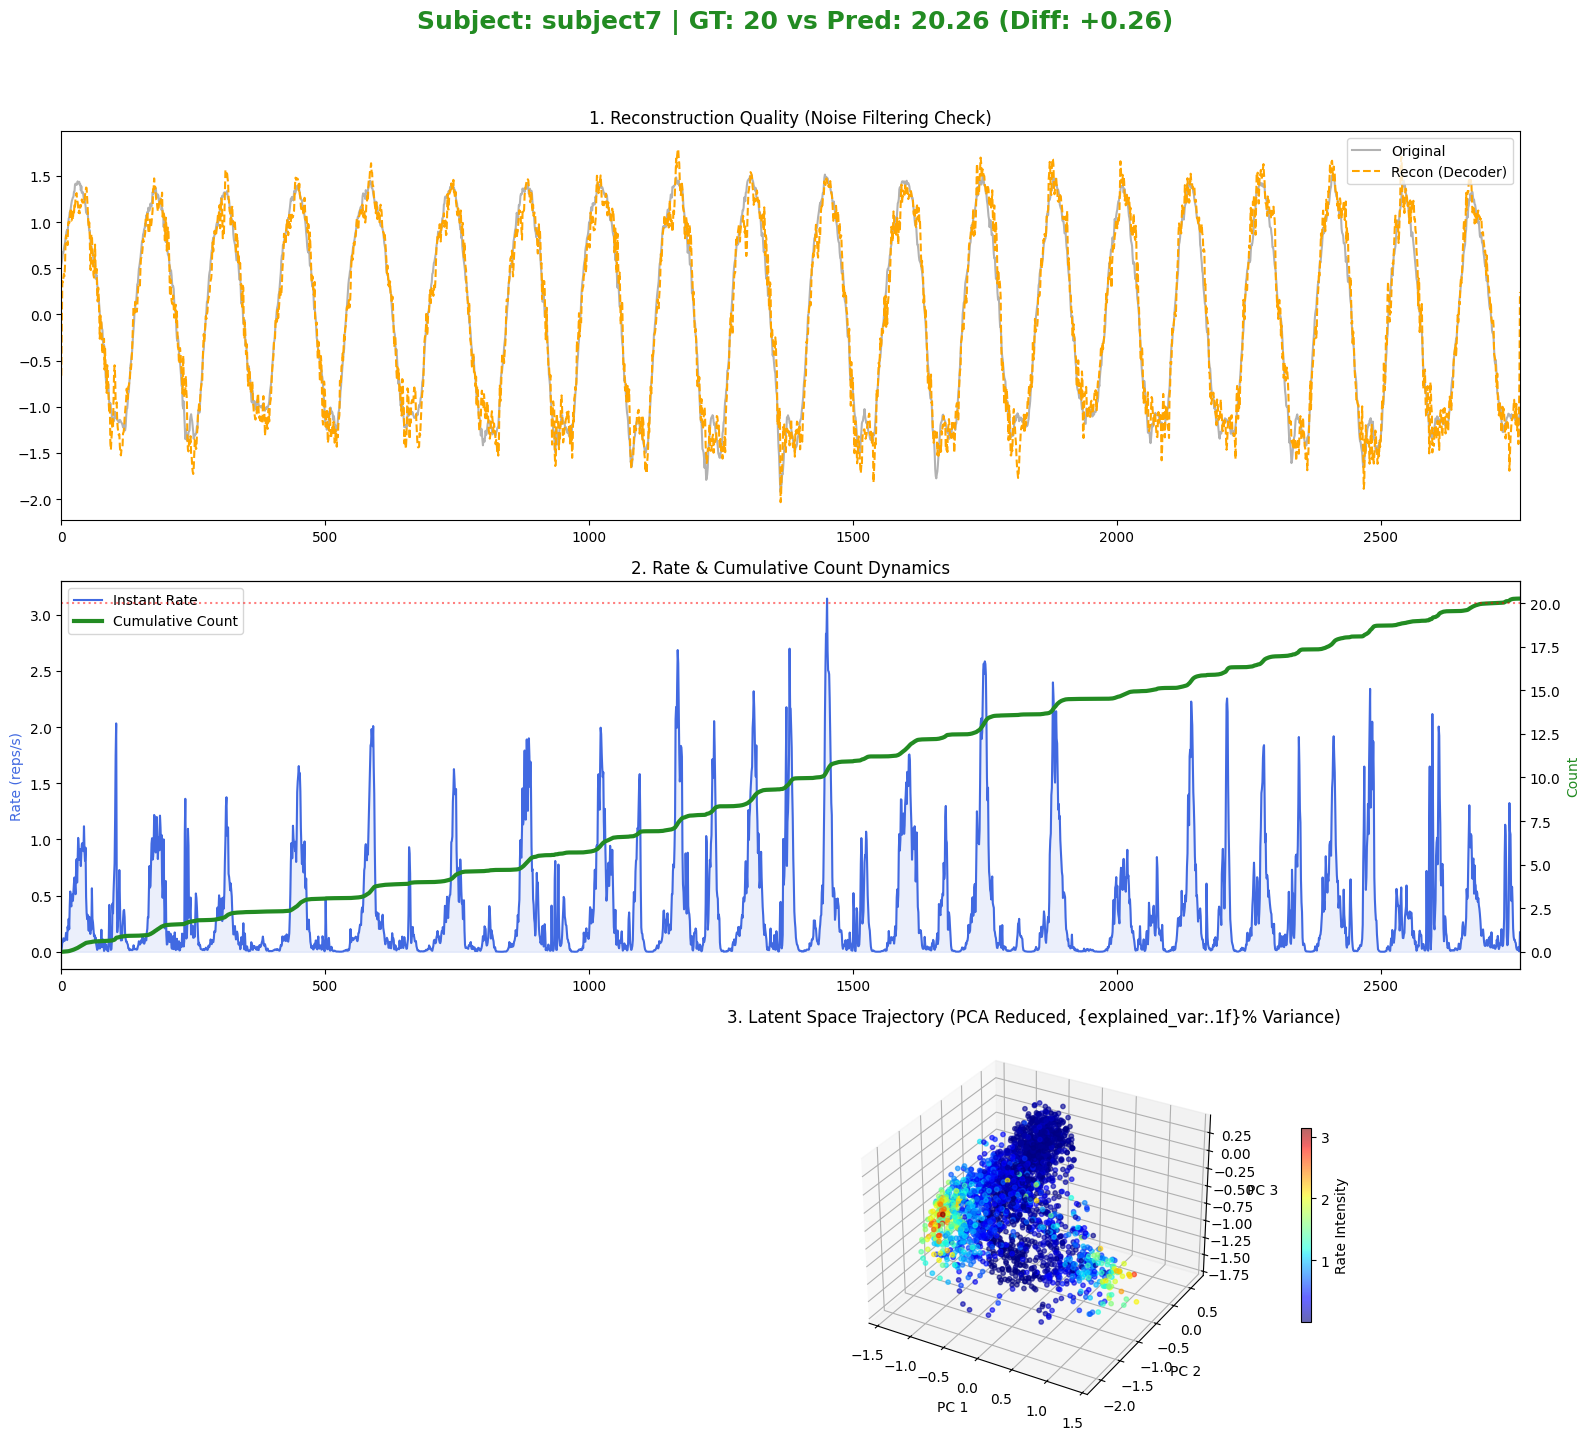

Done subject7...



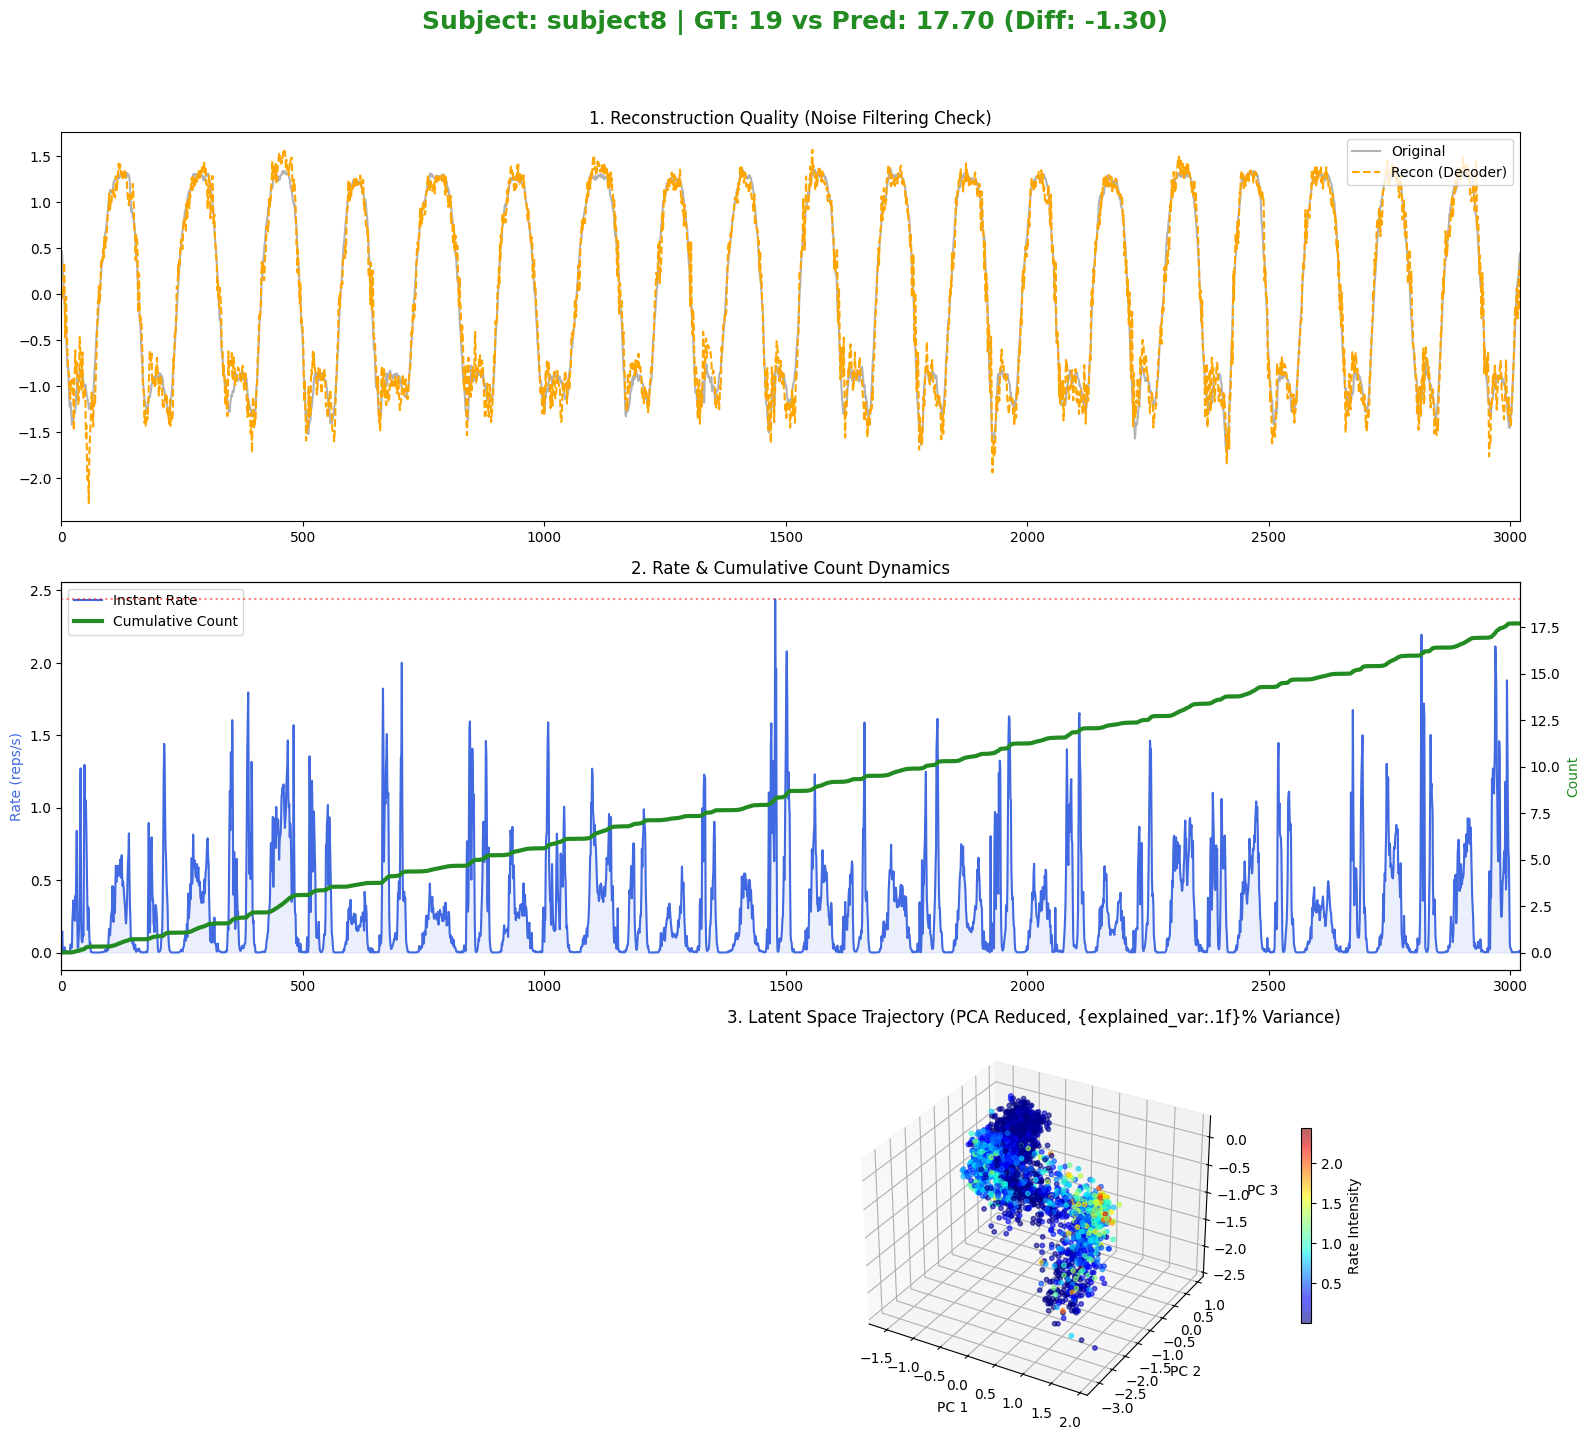

Done subject8...



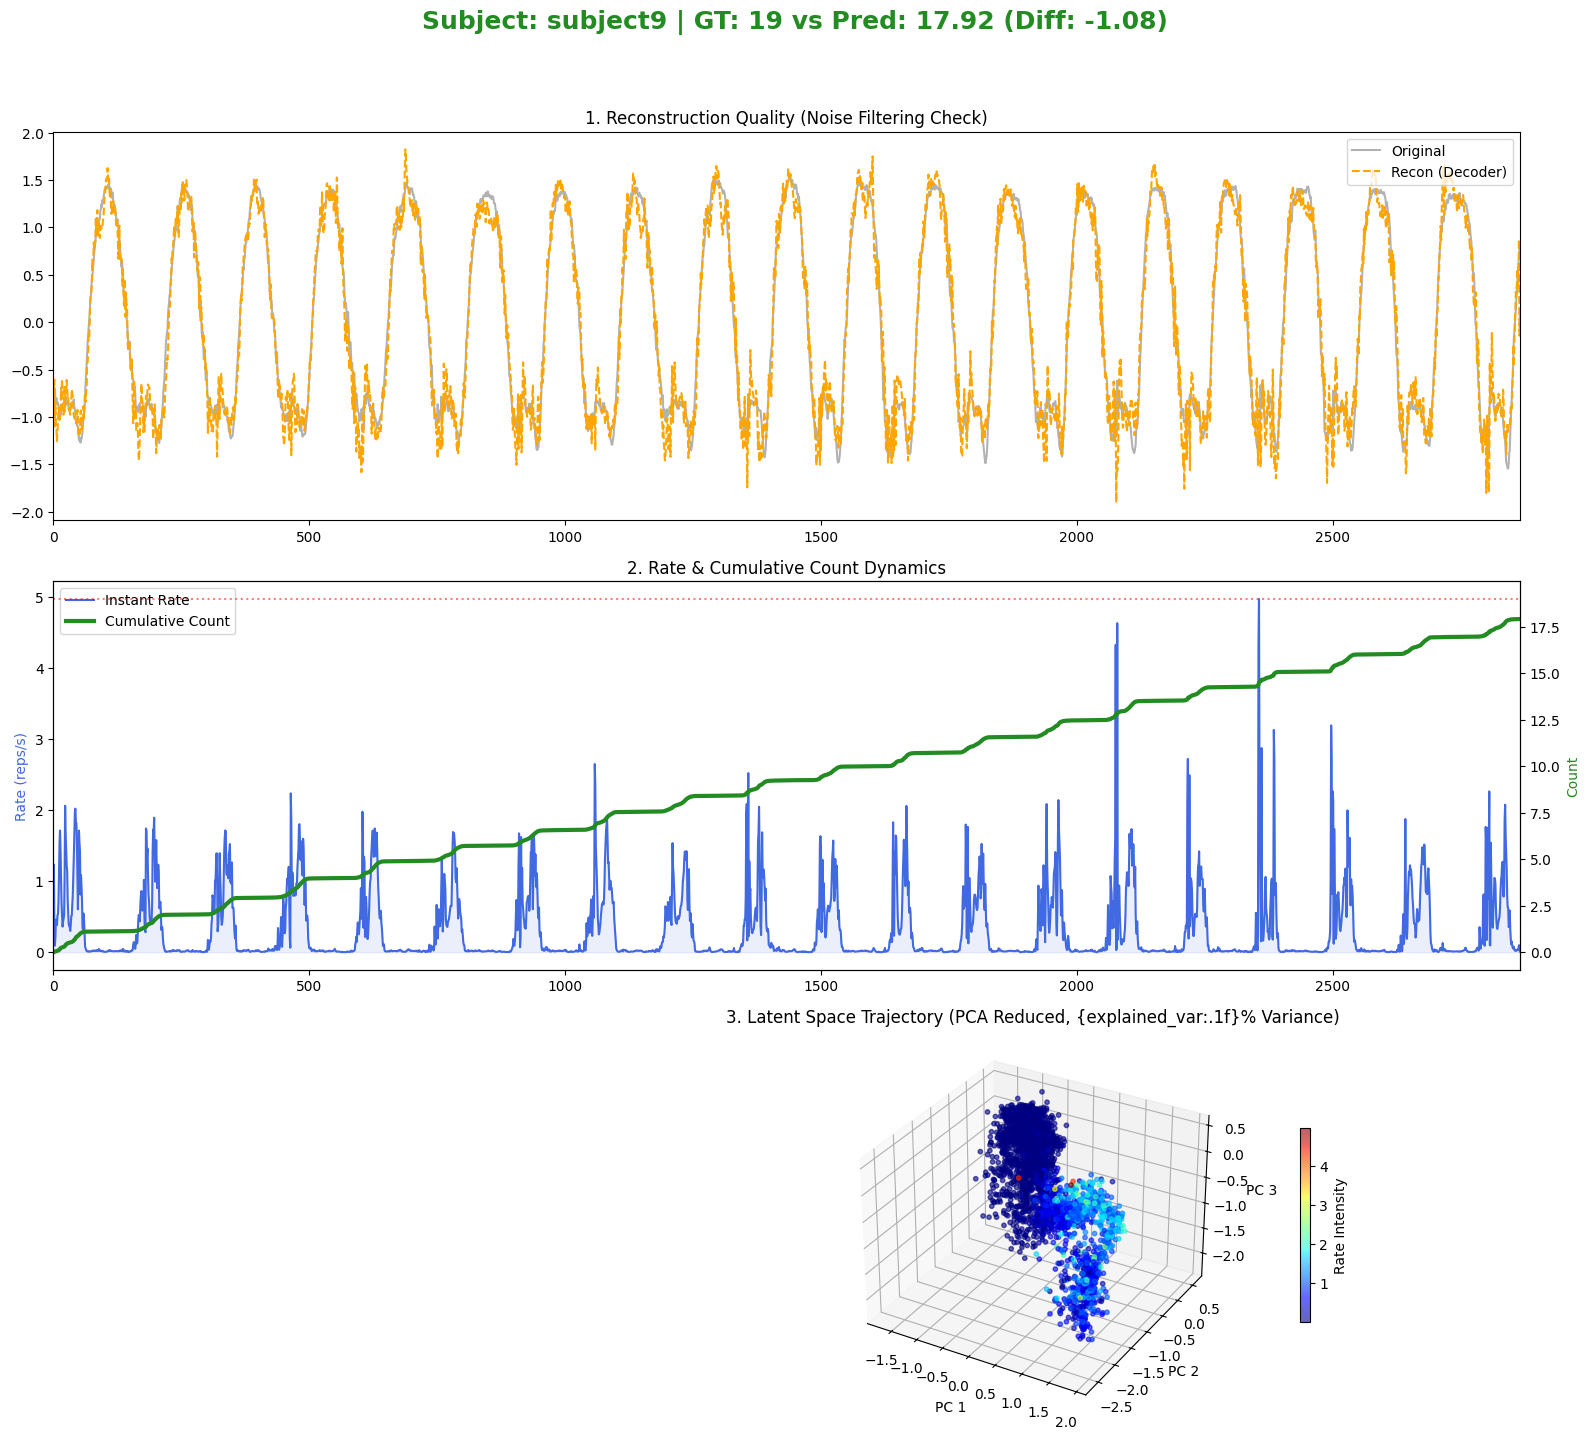

Done subject9...



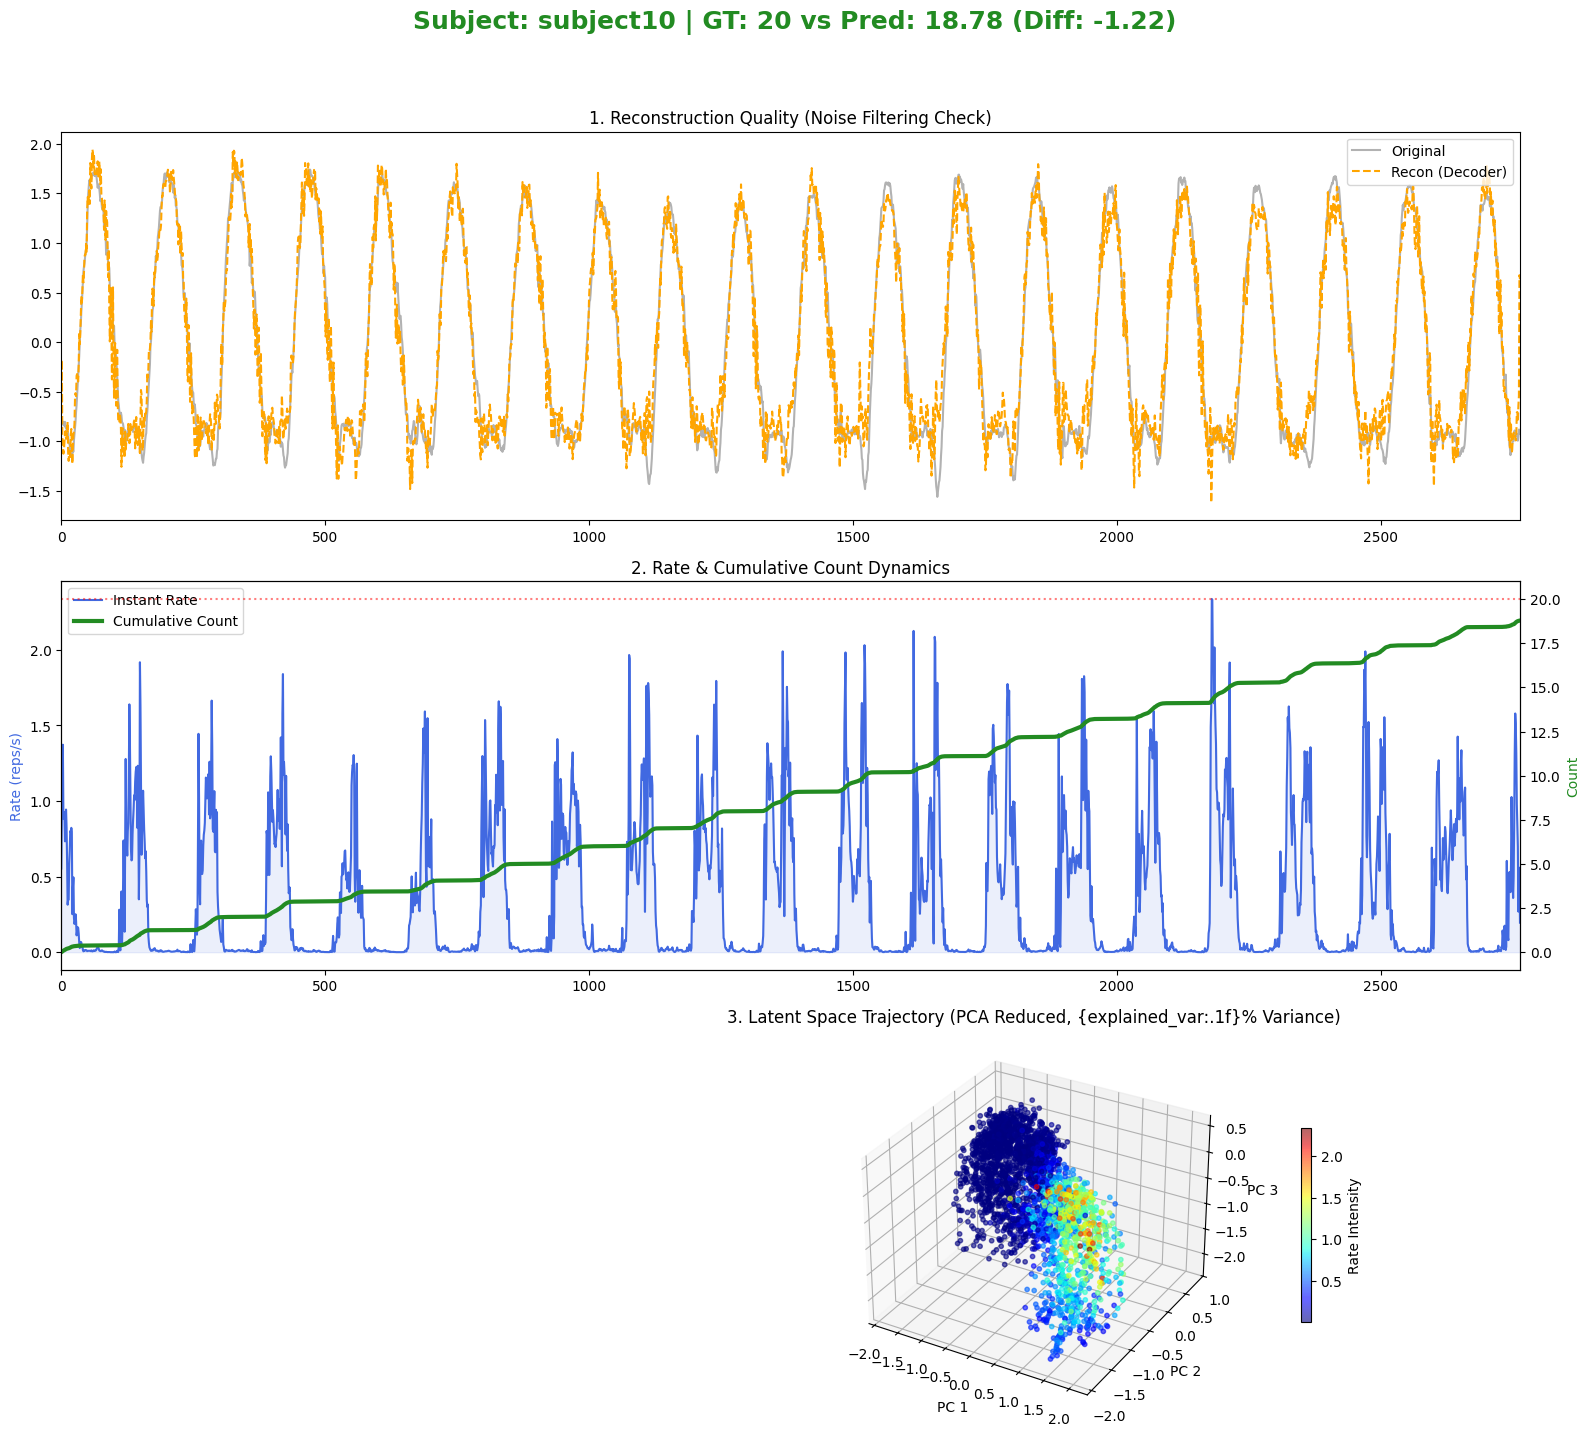

Done subject10...



In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------------------------
# 1. Strict Seeding
# ------------------------------------------------------------------------------
def set_strict_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ------------------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset

def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            # Get raw data (N, C)
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Normalize (Z-score per trial)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ------------------------------------------------------------------------------
# 3. Model Classes
# ------------------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=3):
        super().__init__()
        # Global pooling to capture window context if used primarily for reconstruction
        # But for sequence processing, we might want to keep temporal dimension
        # Here we use a architecture that preserves T somewhat or encodes window
        # For simplicity in this 'Trial-based' approach, let's keep it simple:
        # Encoder: (B, C, T) -> (B, D, T) mapping strictly time-wise

        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1) # Project to latent
        )

    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x) # (B, D, T)
        z = z.transpose(1, 2) # (B, T, D) for easier handling later
        return z

class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        # z: (B, T, D) -> (B, D, T) 로 바꾼 뒤 Conv1d로 복원
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)  # 최종 채널을 입력 채널 C로
        )

    def forward(self, z):
        # z: (B, T, D)
        zt = z.transpose(1, 2)       # (B, D, T)
        x_hat = self.net(zt)         # (B, C, T)
        return x_hat

class RateHead(nn.Module):
    def __init__(self, latent_dim=3, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, z):
        # z: (B, T, D)
        return self.net(z).squeeze(-1)  # (B, T)

class RateModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=64):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = RateHead(latent_dim, hidden_dim)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        # softplus로 양수 rate
        nn.init.constant_(self.rate_head.net[-1].bias, -2.0)

    def forward(self, x, mask=None):
        # x: (B, C, T)
        z = self.encoder(x)  # (B, T, D)
        x_hat = self.decoder(z)  # (B, C, T)

        rate_logits = self.rate_head(z)
        instant_rate = F.softplus(rate_logits)

        if mask is None:
            avg_rate = instant_rate.mean(dim=1)  # (B, )
        else:
            mask = mask.to(dtype=instant_rate.dtype, device=instant_rate.device)
            avg_rate = (instant_rate * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        return avg_rate, z, x_hat


# ------------------------------------------------------------------------------
# 4. Dataset & Collate
# ------------------------------------------------------------------------------
class TrialDataset(Dataset):
    """
    Wraps the loaded data to provide (sequence, count, meta)
    Compatible with Variable Length Collate
    """
    def __init__(self, trial_list):
        # trial_list: list of dicts {'data': np.array(T, C), 'count': float, 'meta': str}
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1) # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']

def collate_variable_length(batch):
    # batch: list of (data, count, meta)
    # data: (C, T)

    # 1. Find max length
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []

    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        # Pad data
        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data), # (B, C, T_max)
        "mask": torch.stack(masks),       # (B, T_max)
        "count": torch.stack(counts),     # (B,)
        "length": torch.tensor(lengths, dtype=torch.float32),  # (B,)
        "meta": metas
    }


# ------------------------------------------------------------------------------
# 5. Training
# ------------------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    """
    x_hat, x: (B, C, T)
    mask: (B, T)  (1=유효, 0=pad)
    """
    mask = mask.to(dtype=x.dtype, device=x.device)          # (B,T)
    mask_bc = mask.unsqueeze(1)                              # (B,1,T)
    se = (x_hat - x) ** 2                                    # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps                  # B*T_valid*C
    return se.sum() / denom

def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in ['loss', 'loss_rate', 'loss_recon', 'mae_rate', 'mae_count']}

    fs = config["fs"]
    lam_recon = config.get("lambda_recon", 1.0)

    for batch in loader:
        x = batch["data"].to(device)        # (B, C, T)
        mask = batch["mask"].to(device)     # (B, T)
        y_count = batch["count"].to(device) # (B,)
        length = batch["length"].to(device) # (B,)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration

        optimizer.zero_grad()

        rate_hat, z, x_hat = model(x, mask)

        loss_rate = F.mse_loss(rate_hat, y_rate)
        loss_recon = masked_recon_mse(x_hat, x, mask)
        loss = loss_rate + lam_recon * loss_recon

        loss.backward()
        optimizer.step()

        count_hat = rate_hat * duration

        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['mae_rate'] += torch.abs(rate_hat - y_rate).mean().item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v/n for k, v in stats.items()}


# ------------------------------------------------------------------------------
# 6. Inference
# ------------------------------------------------------------------------------
def evaluation(model, trial_data, device, fs, gt_count=None):
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(trial_data, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)  # (1,C,T)
        T = trial_data.shape[0]
        duration = T / fs

        rate_hat, _ = model(x_tensor, mask=None)   # (1,)
        rate_val = rate_hat.item()
        count_val = rate_val * duration

    gt_str = f"{gt_count:.2f}" if gt_count is not None else "Unknown"
    print("-" * 50)
    print(f">>> Pred count: {count_val:.2f} | (rate={rate_val:.3f} reps/s, duration={duration:.2f}s) | GT: {gt_str}")
    print("-" * 50)
    return count_val


# ------------------------------------------------------------------------------
# 7. Main with CONFIG
# ------------------------------------------------------------------------------
def main():

    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
            7: 'Frontal elevation of arms',
            8: 'Knees bending',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
            7: ['acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'],
            8: ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z'],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,  # Small batch size since sequences are long
        "fs": 50,

        # Loss Weihgts
        "lambda_recon": 1.0,

        # Model Arch
        "hidden_dim": 128,
        "latent_dim": 16,

        "ALL_LABELS": [
            # (Subject_ID, Activity_ID, True_Count)
            ("subject1", 7, 20),
            ("subject2", 7, 20),
            ("subject3", 7, 20),
            ("subject4", 7, 20),
            ("subject5", 7, 20),
            ("subject6", 7, 20),
            ("subject7", 7, 20),
            ("subject8", 7, 19),
            ("subject9", 7, 19),
            ("subject10", 7, 20),
        ],

    }

    # 1. Setup
    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data: return

    # 2. LOSO Loop
    subjects = [f"subject{i}" for i in range(1, 11)] # subject1 ~ subject10
    loso_results = []

    print("\n" + "-"*50)
    print(" >>> Starting Leave-One-Subject-Out (LOSO) CV")
    print("-"*50)

    for fold_idx, test_subj in enumerate(subjects):
        set_strict_seed(CONFIG["seed"])
        # -------------------------------------------------
        # A. Split Data (Deterministic)
        # -------------------------------------------------
        train_labels = [x for x in CONFIG["ALL_LABELS"] if x[0] != test_subj]
        test_labels =  [x for x in CONFIG["ALL_LABELS"] if x[0] == test_subj]

        # 데이터가 없는 Subject는 건너뜀 (예: 파일이 없거나 로드 실패 시)
        # prepare_trial_list 내부에서 체크하지만, 리스트가 비면 루프 진행 불가
        train_data = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
        test_data = prepare_trial_list(test_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])

        if not test_data:
            print(f"[Skip] Fold {fold_idx+1}: {test_subj} has no data.")
            continue

        g = torch.Generator()
        g.manual_seed(CONFIG["seed"])
        train_loader = DataLoader(TrialDataset(train_data), batch_size=CONFIG["batch_size"],
                                  shuffle=True, collate_fn=collate_variable_length, generator=g,
                                  num_workers=0)

        # -------------------------------------------------
        # B. Reset Model & Seed (Critical for Reproducibility)
        # -------------------------------------------------

        input_ch = train_data[0]['data'].shape[1]
        model = RateModel(input_ch=input_ch, hidden_dim=CONFIG["hidden_dim"], latent_dim=CONFIG["latent_dim"]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

        # -------------------------------------------------
        # C. Training
        # -------------------------------------------------
        # print(f"Fold {fold_idx+1} | Test: {test_subj} | Training...", end="")
        for epoch in range(CONFIG["epochs"]):
            loss = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
            scheduler.step()

        # -------------------------------------------------
        # D. Evaluation
        # -------------------------------------------------
        model.eval()
        fold_mae = 0.0
        fold_res_str = ""

        for item in test_data:
            with torch.no_grad():
                x_tensor = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                duration = x_tensor.shape[2] / CONFIG["fs"]

                rate_hat, _, _ = model(x_tensor, mask=None)
                count_pred = rate_hat.item() * duration
                count_gt = item['count']

                abs_err = abs(count_pred - count_gt)
                fold_mae += abs_err
                fold_res_str += f"[Pred: {count_pred:.1f} / GT: {count_gt:.0f}]"

        fold_mae /= len(test_data)
        loso_results.append(fold_mae)

        print(f"Fold {fold_idx+1:2d} | Test: {test_subj} | MAE: {fold_mae:.2f} | {fold_res_str}")

    # 3. Final Report
    print("="*50)
    print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
    print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
    print("="*50)

# ------------------------------------------------------------------------------
# 8. Visualization
# ------------------------------------------------------------------------------
    def visualize_all_subjects(model, full_data, config, device):
        print("="*60)
        print(" >>> Visualizing All 10 Subjects")
        print("="*60)

        # 전체 리스트 순회
        subject_list = [f"subject{i}" for i in range(1, 11)]

        # 정답(GT) 딕셔너리 만들기 (빠른 조회를 위해)
        gt_map = {}
        for item in config["ALL_LABELS"]:
            # item: ("subject1", 12, 40)
            key = item[0] # subject1
            count = item[2]
            gt_map[key] = count

        # Loop 시작
        for subj_id in subject_list:
            if subj_id not in full_data:
                print(f"[Skip] No data for {subj_id}")
                continue

            # -------------------------------------------------
            # 1. 데이터 준비
            # -------------------------------------------------
            target_act_id = 7
            act_name = config["TARGET_ACTIVITIES_MAP"][target_act_id]
            feats = config["ACT_FEATURE_MAP"][target_act_id]

            # 데이터 추출 및 정규화
            if act_name not in full_data[subj_id]:
                continue

            raw_df = full_data[subj_id][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            # -------------------------------------------------
            # 2. 모델 추론
            # -------------------------------------------------
            model.eval()
            with torch.no_grad():
                x_tensor = torch.tensor(norm_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                rate_hat, z, x_hat = model(x_tensor)

                rate_logits = model.rate_head(z)
                instant_rate = F.softplus(rate_logits).squeeze().cpu().numpy()

                # (1) Latent 벡터 원본 (Shape: Time x 16)
                z_np = z.squeeze().cpu().numpy()

                # (2) [수정됨] PCA 적용하여 16차원 -> 3차원 압축
                # 16개 차원 중 분산(정보량)이 가장 큰 3개 축을 자동으로 찾습니다.
                pca = PCA(n_components=3)
                z_pca = pca.fit_transform(z_np) # 결과 Shape: (Time x 3)

                # 정보 보존율 확인 (선택 사항)
                explained_var = np.sum(pca.explained_variance_ratio_) * 100

                x_hat_np = x_hat.squeeze().permute(1, 0).cpu().numpy()

                # 예측값 계산 등... (기존 동일)
                duration = x_tensor.shape[2] / config["fs"]
                pred_count = instant_rate.mean() * duration
                gt_count = gt_map.get(subj_id, 0)
                diff = pred_count - gt_count
                error_color = 'red' if abs(diff) > 5.0 else 'forestgreen'

            # -------------------------------------------------
            # 3. 시각화 (3 Rows)
            # -------------------------------------------------
            fig = plt.figure(figsize=(16, 15))
            plt.suptitle(f"Subject: {subj_id} | GT: {gt_count} vs Pred: {pred_count:.2f} (Diff: {diff:+.2f})",
                        fontsize=18, fontweight='bold', color=error_color)

            # 대표 채널 자동 선택 (분산 가장 큰 축)
            main_ch_idx = np.argmax(np.var(norm_np, axis=0))

            # [Row 1] Reconstruction
            ax1 = fig.add_subplot(3, 1, 1)
            ax1.plot(norm_np[:, main_ch_idx], 'k', alpha=0.3, label='Original')
            ax1.plot(x_hat_np[:, main_ch_idx], 'orange', linestyle='--', label='Recon (Decoder)')
            ax1.set_title("1. Reconstruction Quality (Noise Filtering Check)")
            ax1.legend(loc='upper right')
            ax1.margins(x=0)

            # [Row 2] Temporal Dynamics
            ax2 = fig.add_subplot(3, 1, 2)
            t_axis = np.arange(len(instant_rate))
            ln1 = ax2.plot(t_axis, instant_rate, 'royalblue', label='Instant Rate')
            ax2.fill_between(t_axis, instant_rate, color='royalblue', alpha=0.1)
            ax2.set_ylabel('Rate (reps/s)', color='royalblue')

            ax2_r = ax2.twinx()
            cum_cnt = np.cumsum(instant_rate) / config["fs"]
            ln2 = ax2_r.plot(t_axis, cum_cnt, 'forestgreen', linewidth=3, label='Cumulative Count')
            ax2_r.set_ylabel('Count', color='forestgreen')

            # GT 라인 그리기 (Target Count)
            ax2_r.axhline(y=gt_count, color='red', linestyle=':', alpha=0.5, label=f'GT: {gt_count}')

            # Legend 통합
            lns = ln1 + ln2
            labs = [l.get_label() for l in lns] + [f'GT: {gt_count}']
            ax2.legend(lns, labs, loc='upper left')
            ax2.set_title("2. Rate & Cumulative Count Dynamics")
            ax2.margins(x=0)

            # [Row 3] Latent Manifold
            ax3 = fig.add_subplot(3, 1, 3, projection='3d')
            p = ax3.scatter(z_np[:,0], z_np[:,1], z_np[:,2], c=instant_rate, cmap='jet', s=10, alpha=0.6)
            ax3.set_title("3. Latent Space Trajectory (PCA Reduced, {explained_var:.1f}% Variance)")
            ax3.set_xlabel('PC 1')
            ax3.set_ylabel('PC 2')
            ax3.set_zlabel('PC 3')
            fig.colorbar(p, ax=ax3, shrink=0.5, label='Rate Intensity')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Title 공간 확보
            plt.show()

            print(f"Done {subj_id}...\n")

    # 실행
    visualize_all_subjects(model, full_data, CONFIG, device)

if __name__ == "__main__":
    main()